# سلفني: تحليل بيانات القروض الشخصية (Sellefni: Personal Loan Analysis)
### سنقوم في هذا التحليل ببناء نموذج تخميني للقروض الشخصية.
### تحت شعار: سلفني حتى للنهار اللي ماعندو سمية.

## استيراد المكتبات (Importing Libraries)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
!pip install arabic-reshaper > /dev/null 2>&1
import arabic_reshaper
from bidi.algorithm import get_display
import warnings
warnings.filterwarnings("ignore")

# هذه الدالة هي لدعم طبع نصوص محبوبتنا الجميلة (العربية) على الرسوم البيانية
def ara_text(arabic_text):
    reshaped_text = arabic_reshaper.reshape(arabic_text)
    return get_display(reshaped_text)


## تحميل البيانات (Loading the Data)

In [2]:
file_path = '/kaggle/input/sellefni-personal-loan-dataset/Sellefni_Personal_Loan_DataSet.csv'
df = pd.read_csv(file_path)

## تحويل المتغيرات الفئوية (Convert Categorical Variables)

In [3]:
category_cols = ['Personal Loan', 'Securities Account', 'Family', 'CD Account', 'Online', 'CreditCard', 'ZIP Code', 'Education']
df[category_cols] = df[category_cols].astype('category')

## التعامل مع القيم السلبية (Handle Negative Values)

In [4]:
df[df['Experience'] < 0].sort_values(by='Experience')

df['Experience'] = df['Experience'].apply(lambda x: 0 if x < 0 else x)

negative_experience_count = df[df['Experience'] < 0].shape[0]
print(f"عدد القيم السالبة المتبقية في عمود 'Experience': {negative_experience_count}")


عدد القيم السالبة المتبقية في عمود 'Experience': 0


## تحليل التوزيع (Distribution Analysis)

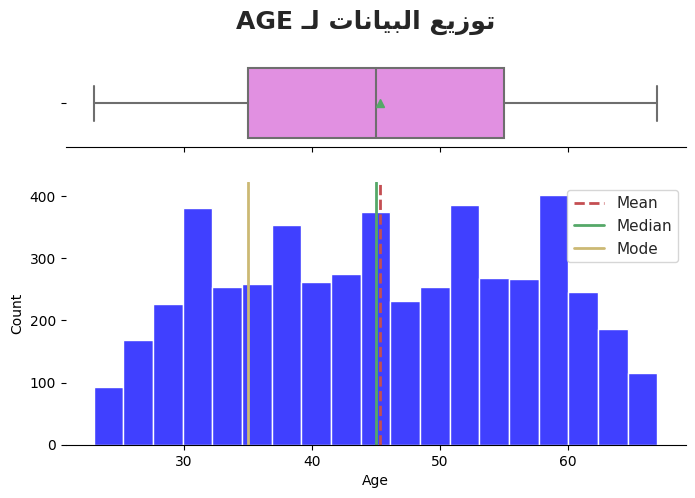

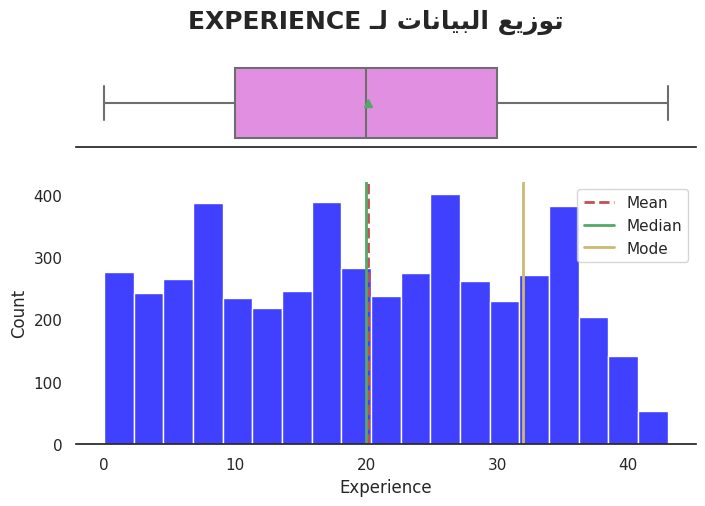

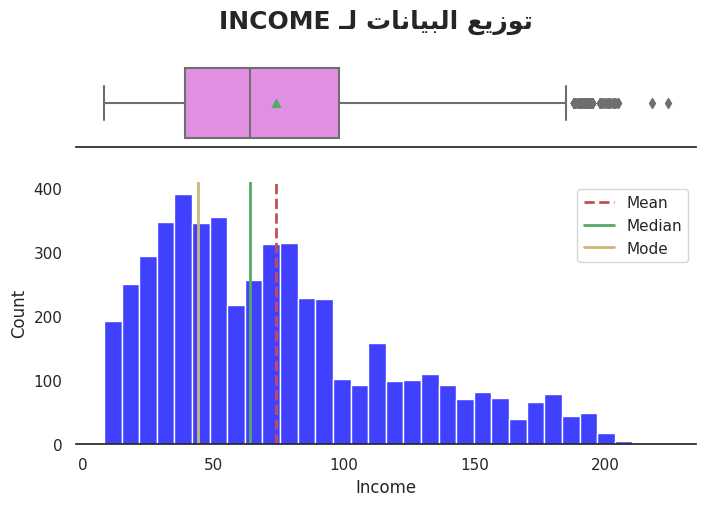

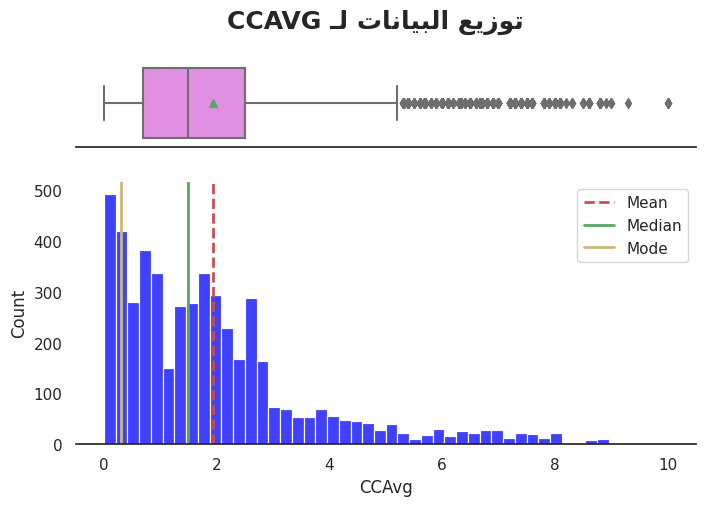

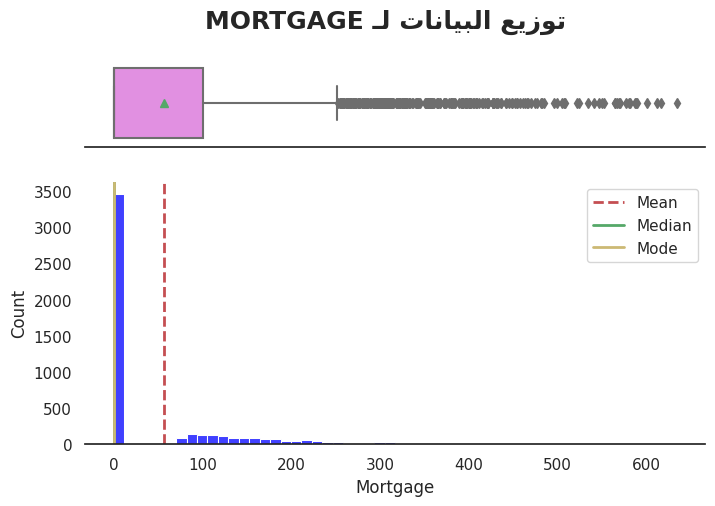

In [5]:
def dist_box(data):
    Name = data.name.upper()
    fig, (ax_box, ax_dis) = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)}, figsize=(8, 5))
    mean = data.mean()
    median = data.median()
    mode = data.mode().tolist()[0]
    sns.set_theme(style="white")
    fig.suptitle(ara_text("توزيع البيانات لـ " + Name), fontsize=18, fontweight='bold')
    sns.boxplot(x=data, showmeans=True, orient='h', color="violet", ax=ax_box)
    ax_box.set(xlabel='')
    sns.despine(top=True, right=True, left=True)
    sns.histplot(data, kde=False, color='blue', ax=ax_dis)
    ax_dis.axvline(mean, color='r', linestyle='--', linewidth=2)
    ax_dis.axvline(median, color='g', linestyle='-', linewidth=2)
    ax_dis.axvline(mode, color='y', linestyle='-', linewidth=2)
    plt.legend({'Mean': mean, 'Median': median, 'Mode': mode})
    plt.show()

continuous_cols = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
for col in continuous_cols:
    dist_box(df[col])

## بناء النموذج وتدريبه (Model Building and Training)

In [6]:
# تجهيز البيانات للتدريب (Prepare data for training)
X = df.drop(['ID', 'Personal Loan'], axis=1)
y = df['Personal Loan'].astype(int)

# تقسيم البيانات إلى تدريب واختبار (Split the data into training and testing sets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  

# توحيد مقياس الميزات (Scale the features)
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# تدريب نموذج الغابة العشوائية (Train a Random Forest model)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# إجراء التنبؤات على بيانات الاختبار (Make predictions on test data)
y_pred = model.predict(X_test)

# تقييم أداء النموذج (Evaluate the model's performance)
print("دقة النموذج:", accuracy_score(y_test, y_pred))
print("تقرير التصنيف:")
print(classification_report(y_test, y_pred))


دقة النموذج: 0.99
تقرير التصنيف:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1343
           1       0.99      0.91      0.95       157

    accuracy                           0.99      1500
   macro avg       0.99      0.96      0.97      1500
weighted avg       0.99      0.99      0.99      1500



## اختبار بيانات جديدة (Test with New Data)

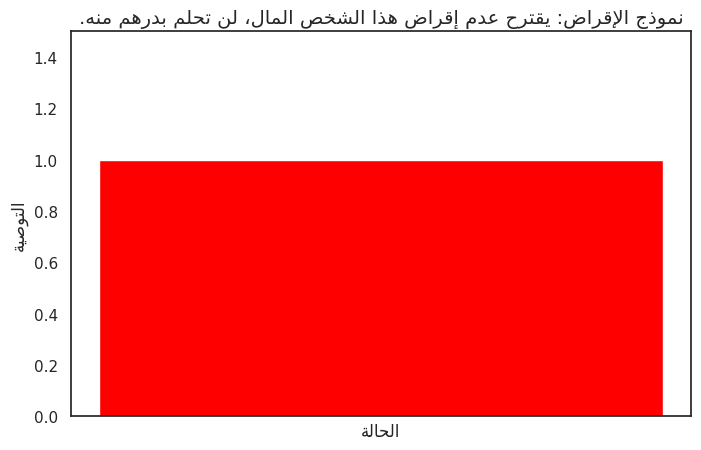

In [7]:
# بيانات الشخص الجديد (New person's data)
new_data = {
    'Age': 30,
    'Experience': 5,
    'Income': 60,
    'ZIP Code': 90210,
    'Family': 3,
    'CCAvg': 2.5,
    'Education': 1,
    'Mortgage': 0,
    'Securities Account': 0,
    'CD Account': 1,
    'Online': 1,
    'CreditCard': 0
}

# تحويل البيانات الجديدة إلى DataFrame وتطبيق مقياس التوحيد (Convert to DataFrame and scale)
new_df = pd.DataFrame([new_data])
new_scaled_data = scaler.transform(new_df[X.columns])

# إجراء التنبؤ (Make prediction)
prediction = model.predict(new_scaled_data)

# عرض النتيجة في مبيان (Visualize result)
plt.figure(figsize=(8, 5))
plt.ylim(0, 1.5)

if prediction[0] == 1:
    plt.bar(ara_text("توصية القرض"), 1, color="green")
    plt.title(ara_text("نموذج الإقراض: هذا الشخص يُحتمل أن يرد لك مالك، فكر في الأمر."), fontsize=14)
    plt.text(0, 1.05, ara_text("هذا الشخص يُحتمل أن يرد لك مالك"), fontsize=12, ha='center', color='white')
    #print("نموذج الإقراض: هذا الشخص يُحتمل أن يرد لك مالك، فكر في الأمر.")
else:
    plt.bar(ara_text("توصية القرض"), 1, color="red")
    plt.title(ara_text("نموذج الإقراض: يُقترح عدم إقراض هذا الشخص المال، لن تحلم بدرهم منه."), fontsize=14)
    plt.text(0, 1.05, ara_text("يُقترح عدم إقراض هذا الشخص المال"), fontsize=12, ha='center', color='white')
    #print("نموذج الإقراض: يُقترح عدم إقراض هذا الشخص المال، لن تحلم بدرهم منه.")

plt.xlabel(ara_text("الحالة"))
plt.ylabel(ara_text("التوصية"))
plt.xticks([])
plt.show()